## Stroke Work
<b>Author:</b> Daniel Maina Nderitu<br>
<b>Project:</b> MADIVA<br>
<b>Purpose:</b> Sensitivity Analysis<br>
<b>Notes:</b> If I slightly change my model assumptions or inputs - do my results still hold?

In [16]:
import plotly.express as px

#### Bootstrap cell

In [17]:
# =================== BOOTSTRAP CELL ===================
# Standard setup for all notebooks
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parents[0]  # assumes notebooks are in a subfolder
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# ========================================================
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

from src.config.variables import COVARIATES

# ========================================================
# Optional for warnings and nicer plots
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

import sys
from pathlib import Path

# ========================================================
# 1️⃣ Ensure project root is in Python path
# Adjust this if your notebooks are nested deeper
PROJECT_ROOT = Path.cwd().parents[0]  # assumes notebooks are in a subfolder
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# ========================================================
# 2️⃣ Import helper to load paths
from src.utils.helpers import load_paths

# ========================================================
# 3️⃣ Load paths from config.yaml (works regardless of notebook location)
paths = load_paths()

# ========================================================
# 4️⃣ Optionally, print paths to confirm
for key, value in paths.items():
    print(f"{key}: {value}")

# ========================================================
# 5️⃣ Now you can use these paths in your notebook:
# Example:
DATA_DIR = paths['DATA_DIR']
OUT_DIR = paths['OUT_DIR']
FIG_DIR = paths['FIG_DIR']
MODEL_DIR = paths['MODEL_DIR']
# ========================================================

BASE_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work
DATA_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\data
OUT_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\model_output
FIG_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\visualization
MODEL_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\model_output\statsmodels
NOTEBOOKS_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\notebooks
NOTEBOOKS_EXECUTED_DIR: D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work\notebooks_executed


### Import data - from previous step

In [18]:
# -----------------------------------------------------------------------------
# Loading saved data as pickle:
# -----------------------------------------------------------------------------
df = pd.read_pickle(OUT_DIR / "df_step07_ii_processed.pkl")
X = pd.read_pickle(OUT_DIR / "X_step07_ii_model_matrix.pkl")
y = pd.read_pickle(OUT_DIR / "y_step07_ii_event.pkl")
study_periods = pd.read_pickle(OUT_DIR / "study_periods.pkl")

results_pois = pd.read_pickle(OUT_DIR / "results_pois.pkl")
results_robust = pd.read_pickle(OUT_DIR / "results_robust.pkl")
results_nb = pd.read_pickle(OUT_DIR / "results_nb.pkl")
all_results = pd.read_pickle(OUT_DIR / "df_step07_all_results.pkl")

# -----------------------------------------------------------------------------
# Loading saved models as pickle:
# -----------------------------------------------------------------------------
import pickle

with open(MODEL_DIR / "model_pois.pkl", "rb") as f:
    model_pois = pickle.load(f)

with open(MODEL_DIR / "model_robust.pkl", "rb") as f:
    model_robust = pickle.load(f)

with open(MODEL_DIR / "model_nb.pkl", "rb") as f:
    model_nb = pickle.load(f)

#### Add intercept

In [19]:
X_full = sm.add_constant(X)

#### Loop sensitivity models (Sensitivity Analysis A)

In [20]:
results = []

for var in COVARIATES:
    
    covs = [v for v in COVARIATES if v != var]
    X_sens = sm.add_constant(X[covs])

    model = sm.GLM(y, X_sens, family=sm.families.Poisson()).fit()

    results.append({
        "removed_variable": var,
        "AIC": model.aic,
        "BIC": model.bic,
        "loglik": model.llf
    })

sens_df = pd.DataFrame(results)
sens_df.sort_values("AIC")

,removed_variable,AIC,BIC,loglik
3,hpt_status_derived,6334.067196,-288974.164424,-3159.033598
4,diab_status_derived,6335.268168,-288972.963452,-3159.634084
5,bmi_category_Overweight_Obese,53951.925713,-241356.305907,-26967.962856
7,site_Nairobi,54482.838964,-240825.392656,-27233.419482
0,sex_binary,55542.510159,-239765.721460,-27763.255080
2,tobacco_use,56065.158814,-239243.072806,-28024.579407
6,hiv_status_derived,56851.508181,-238456.723439,-28417.754091
1,alcohol_use,63126.225695,-232182.005925,-31555.112847


In [21]:
sens_df.to_csv(MODEL_DIR / "sensitivity_covariate_drop.csv", index=False)
sens_df

,removed_variable,AIC,BIC,loglik
0,sex_binary,55542.510159,-239765.721460,-27763.255080
1,alcohol_use,63126.225695,-232182.005925,-31555.112847
2,tobacco_use,56065.158814,-239243.072806,-28024.579407
3,hpt_status_derived,6334.067196,-288974.164424,-3159.033598
4,diab_status_derived,6335.268168,-288972.963452,-3159.634084
5,bmi_category_Overweight_Obese,53951.925713,-241356.305907,-26967.962856
6,hiv_status_derived,56851.508181,-238456.723439,-28417.754091
7,site_Nairobi,54482.838964,-240825.392656,-27233.419482


#### Sensitivity covariate df - dataframe

In [22]:
sens_df.head(10)

,removed_variable,AIC,BIC,loglik
0,sex_binary,55542.510159,-239765.721460,-27763.255080
1,alcohol_use,63126.225695,-232182.005925,-31555.112847
2,tobacco_use,56065.158814,-239243.072806,-28024.579407
3,hpt_status_derived,6334.067196,-288974.164424,-3159.033598
4,diab_status_derived,6335.268168,-288972.963452,-3159.634084
5,bmi_category_Overweight_Obese,53951.925713,-241356.305907,-26967.962856
6,hiv_status_derived,56851.508181,-238456.723439,-28417.754091
7,site_Nairobi,54482.838964,-240825.392656,-27233.419482


In [23]:
print(model_pois.aic)
AIC_full = model_pois.aic
sens = sens_df.copy()
sens["delta_AIC"] = sens["AIC"] - AIC_full
sens_sorted = sens.sort_values("delta_AIC", ascending=False)
sens_sorted

6578.316846877853


,removed_variable,AIC,BIC,loglik,delta_AIC
1,alcohol_use,63126.225695,-232182.005925,-31555.112847,56547.908848
6,hiv_status_derived,56851.508181,-238456.723439,-28417.754091,50273.191334
2,tobacco_use,56065.158814,-239243.072806,-28024.579407,49486.841967
0,sex_binary,55542.510159,-239765.721460,-27763.255080,48964.193312
7,site_Nairobi,54482.838964,-240825.392656,-27233.419482,47904.522117
5,bmi_category_Overweight_Obese,53951.925713,-241356.305907,-26967.962856,47373.608866
4,diab_status_derived,6335.268168,-288972.963452,-3159.634084,-243.048679
3,hpt_status_derived,6334.067196,-288974.164424,-3159.033598,-244.249651


#### delta_AIC Plot

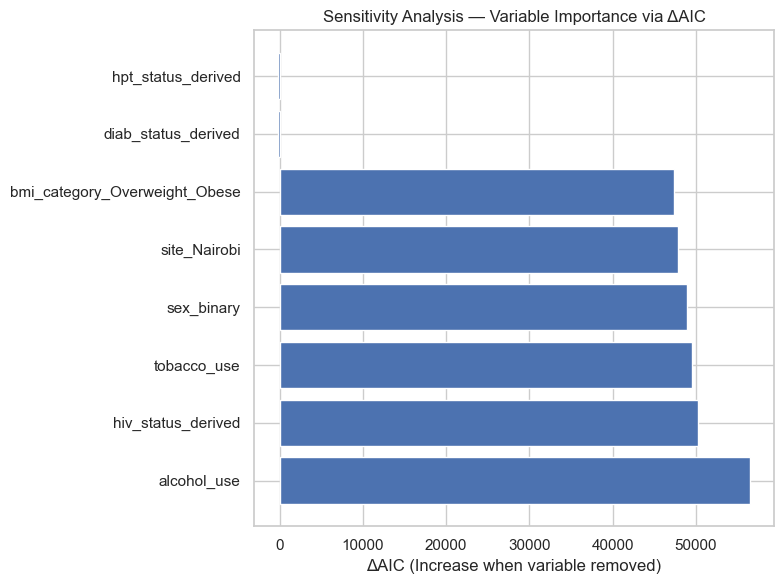

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

plt.barh(
    sens_sorted["removed_variable"],
    sens_sorted["delta_AIC"]
)

plt.xlabel("ΔAIC (Increase when variable removed)")
plt.title("Sensitivity Analysis — Variable Importance via ΔAIC")

plt.tight_layout()
plt.savefig(FIG_DIR / "sensitivity_delta_aic.png", dpi=300)
plt.show()

#### Sensitivity Analysis B — Site-specific models

In [25]:
if "site_Nairobi" in X.columns:

    X_no_site = X.drop(columns=["site_Nairobi"])
    X_no_site = sm.add_constant(X_no_site)

    model_no_site = sm.GLM(y, X_no_site, family=sm.families.Poisson()).fit()

    print("AIC with site:", sm.GLM(y, X_full, family=sm.families.Poisson()).fit().aic)
    print("AIC without site:", model_no_site.aic)

AIC with site: 6177.264848380939
AIC without site: 6199.768474474856


#### Sensitivity Analysis C — Complete-case vs original

In [26]:
X_cc = X.dropna()
y_cc = y.loc[X_cc.index]

model_cc = sm.GLM(
    y_cc,
    sm.add_constant(X_cc),
    family=sm.families.Poisson()
).fit()

print("Complete case AIC:", model_cc.aic)

Complete case AIC: 6177.264848380939


#### Sensitivity Visualization
##### AIC differences

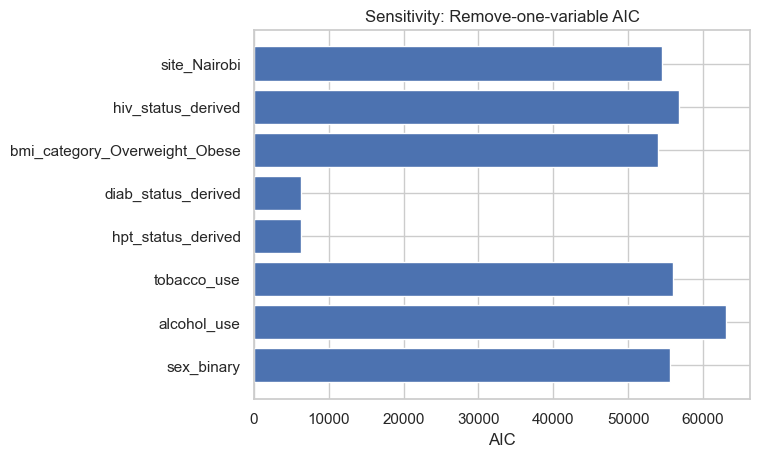

In [27]:
plt.figure()
plt.barh(sens_df["removed_variable"], sens_df["AIC"])
plt.xlabel("AIC")
plt.title("Sensitivity: Remove-one-variable AIC")
plt.savefig(FIG_DIR / "sensitivity_aic.png", dpi=300, bbox_inches="tight")
plt.show()

#### End

In [28]:
# Saved as pickle (faster for large data, preserves types)
df.to_pickle(OUT_DIR / "sens_df.pkl")
sens_sorted.to_csv(
    OUT_DIR / "sensitivity_with_delta_aic.csv",
    index=False
)